In [1]:
### This is the topic modeling jupyter project notebook for The Ciphers of <i>the Times</i>.' 
### Its purpose is to try and find the parameters that would prove most fruitful for topic modeling our project corpora.
### We relied heavily on help from other similar projects, in particular the "Optimizing LDA Topic Model for Interpretability" jupyter notebook
### from nicharuc's github, which can be found here: https://nicharuc.github.io/topic_modeling/#topic=0&lambda=1&term=

### This notebook first defines our topic modeling parameters, our libraries, paths and functions.
### Then it proceeds to clean the text, create bi-grams and tri-grams, and filters out only the words with the NOUN tag.
### It then evaluates the coherence scores for a range of topics between 5 and 25, grabs the top two most coherent topic numbers,
### and uses those outputs for visualization purposes.

In [2]:
### PARAMETERS
## We set up these settings for quick access, so that we could run these analyses quickly, without having to change the notebook 
## for each topic modeling run.

k_one = 0
k_two = 0
no_below_input = 10
no_above_input = 1
passes_amount = 40
iterations_amount = 500

In [3]:
# Ignore warnings that refer to upcoming deprecation changes
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# UTILITY CODE:

# This section is important to be able to open large dataframes, redefining the memory limit.
# Be careful not to mess with this as this can drastically affect memory:

# Data matrix and data frame are huge files, these lines are required to open them:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
# https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072

In [5]:
## Import libraries
import spacy
import nltk

# nltk.download('averaged_perceptron_tagger')
import re
import string
import pandas as pd
pd.set_option("display.max.columns", None)
import numpy as np

import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [6]:
## Paths

## to assets:
path_to_assets = '../../assets/'

## to all spreadsheets:
path_to_spreadsheets = '../../data/spreadsheets/'

df_nnovels_corpus = 'df_nnovels_full.csv'
df_txtlab_corpus = 'df_txtlab_full.csv'

path_to_output = '../../output/'

stop_all = path_to_assets + 'stopall.txt'
stop_names = path_to_assets + 'stopnames.txt'

with open(stop_all, 'r') as stop_all_raw:
    stop_word_list = stop_all_raw.read().split()

In [7]:
### FUNCTIONS 1/2
# Progress bar to follow up on what's happing while running code:
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    
    #old: percents = round(100.0 * count / float(total), 1)
    percents = round(100.1 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#novel_text50529068_27871113)

# for metadata output:
def output_metadata(df, spreadsheet_name='FILL_IN_SPREADSHEET_NAME_META', path_to_spreadsheets=path_to_spreadsheets):
    # setting up list of columns NOT to export (since this is just metadata)
    list_of_columns_not_to_include = ['words_standardized_stopped', 'sentences_standardized_stopless','words_as_string_for_vectorizor', 'dirty_text']
    # all other columns are included
    columns_to_include = [column_name for column_name in df.columns.values.tolist() if column_name.lower() not in list_of_columns_not_to_include]
    df_meta = df[columns_to_include]
    df_meta.to_csv(path_to_spreadsheets + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_to_spreadsheets))
    
# for full output:
def output_full(df, spreadsheet_name='FILL_IN_SPREADSHEET_NAME_FULL', path_to_spreadsheets=path_to_spreadsheets):
    df.to_csv(path_to_spreadsheets + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_to_spreadsheets))

# load a dataframe
def open_df_and_print(file_name='df_full.csv', path_to_spreadsheets=path_to_spreadsheets, drop_first_column=False):
    df = pd.read_csv(path_to_spreadsheets + file_name, engine='python')
    if drop_first_column == True:
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

In [8]:
### FUNCTIONS 2/2
### Cleaning

nlp = spacy.load('en_core_web_sm')

# TODO: set max length automatically
nlp.max_length = 2069077
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    print("finished getting ascii only chars")
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())
    print("finished lowercasing")

    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)
    print("finished lemmatizing")
    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)
    print("finished removing punctuation")
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words


def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final

In [9]:
# ### Load the data
# df_nnovels_full = open_df_and_print(file_name = df_nnovels_corpus, path_output = path, drop_first_column=True)
# df_nnovels_full.head()

In [10]:
# ### Extract only cleaned text
# clean_text = pd.DataFrame(df_nnovels_full.words_as_string_for_vectorizor)
# clean_text = clean_all(clean_text, 'words_as_string_for_vectorizor')

In [11]:
clean_text_nnovels_for_tm_filtered = open_df_and_print(file_name = 'clean_text_nnovels_for_tm_filtered.csv',  path_to_spreadsheets=path_to_spreadsheets, drop_first_column=True)
clean_text_nnovels_for_tm_filtered.head(10)

,words_as_string_for_vectorizor
0,b chapter i the parsonage all true history con...
1,b i the traveler it be the opening of the seas...
2,b chapter i how a rich banker marry an actress...
3,b chapter i along the crisped shade and bower ...
4,b chapter i the house in bloomsbury what about...
5,b chapter I in chancery london michaelmas term...
6,b volume i chapter i mr vavasor and his daught...
7,b cecil it inconvenient to contemplate her bea...
8,b proem not here in our london ghetto the gate...
9,b chapter i man can do nothing without the mak...


In [12]:
# clean_text_nnovels_for_tm_filtered.head()

In [13]:
# output_full(clean_text_nnovels_for_tm_filtered, spreadsheet_name = 'clean_text_nnovels_for_tm_filtered', path_output = './spreadsheets/')

In [14]:
## Form Bigrams and Trigrams for better topics


bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text_nnovels_for_tm_filtered.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)



In [15]:


trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text_nnovels_for_tm_filtered.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)



In [16]:


bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [17]:


trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [18]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [19]:


# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 



In [20]:


# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]



In [21]:
# # examples of bigrams
# bigrams[:10]

In [22]:
# # examples of trigrams
# trigrams[:10]

In [23]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [24]:
novels_w_ngrams = clean_text_nnovels_for_tm_filtered.copy()

In [25]:
# merging ngrams with    "_"
novels_w_ngrams.words_as_string_for_vectorizor = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: replace_ngram(x))

In [26]:


# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
novels_w_ngrams = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and len(word) > 2])



In [27]:
novels_w_ngrams.head()

0    [parsonage, true, history, instruction, treasu...
1    [traveler, opening, season, eighteen_hundred, ...
2    [rich, banker, marry, actress, faint, streak, ...
3    [crisped, shade, bower, revel, spruce, jocund,...
4    [house, bloomsbury, house, whereof, outward, a...
Name: words_as_string_for_vectorizor, dtype: object

In [28]:


# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered



In [29]:
final_texts = novels_w_ngrams.map(noun_only)

In [30]:
### LDA Model Begins

In [31]:
dictionary = corpora.Dictionary(final_texts)
dictionary.filter_extremes(no_below=no_below_input, no_above=no_above_input, keep_n=100000)

In [32]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_texts]

In [33]:


coherence = []
for k in range(80,125):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=passes_amount,\
                   iterations=iterations_amount, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_texts,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))




Round: 80
Round: 81
Round: 82
Round: 83
Round: 84
Round: 85
Round: 86
Round: 87
Round: 88
Round: 89
Round: 90
Round: 91
Round: 92
Round: 93
Round: 94
Round: 95
Round: 96
Round: 97
Round: 98
Round: 99
Round: 100
Round: 101
Round: 102
Round: 103
Round: 104
Round: 105
Round: 106
Round: 107
Round: 108
Round: 109
Round: 110
Round: 111
Round: 112
Round: 113
Round: 114
Round: 115
Round: 116
Round: 117
Round: 118
Round: 119
Round: 120
Round: 121
Round: 122
Round: 123
Round: 124


In [34]:


x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

x_val_copy = x_val.copy()
y_val_copy = y_val.copy()


In [35]:
# grabbing k with highest and second highest coherence
highest_coherence = 0
second_highest_coherence = 0

# Function returns N largest elements
def Nmaxelements(y_vals, x_vals, N):
    final_list = []
  
    for i in range(0, N): 
        max_y = 0
        max_index = 0
        
        for j in range(len(y_vals)):     
            if y_vals[j] > max_y:
                max_index = j
                max_y = y_vals[j]
                max_x = x_vals[j]
                
        y_vals.remove(max_y)
        x_vals.remove(max_x)
        final_list.append(max_x)
          
    print(final_list)
    return final_list
  
# Calling the function
k_one, k_two = Nmaxelements(y_val_copy, x_val_copy, 2)



[91, 105]


In [36]:
print(k_one)
print(highest_coherence)
print(k_two)
print(second_highest_coherence)

91
0
105
0


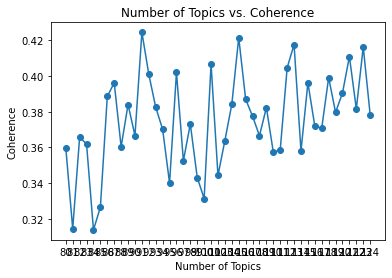

In [37]:


plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()



In [38]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=k_one, id2word = dictionary, passes=passes_amount,\
               iterations=iterations_amount,  chunksize = 10000, eval_every = None, random_state=0)

In [39]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=k_two, id2word = dictionary, passes=passes_amount,\
               iterations=iterations_amount,  chunksize = 10000, eval_every = None, random_state=0)

In [40]:
# To show initial topics from model 1
ldamodel.show_topics(k_one, num_words=15, formatted=False)

[(0,
  [('gutter', 0.00011950287),
   ('gusto', 0.00011950287),
   ('haul', 0.00011950287),
   ('harvest', 0.00011950287),
   ('hardness', 0.00011950287),
   ('harbour', 0.00011950287),
   ('handiwork', 0.00011950287),
   ('handinhand', 0.00011950287),
   ('hammock', 0.00011950287),
   ('hamlet', 0.00011950287),
   ('halo', 0.00011950287),
   ('halldoor', 0.00011950287),
   ('halfsovereign', 0.00011950287),
   ('halfcrown', 0.00011950287),
   ('hack', 0.00011950287)]),
 (1,
  [('guy', 0.0001197492),
   ('time', 0.00011958642),
   ('thing', 0.00011957401),
   ('face', 0.00011954228),
   ('talk', 0.00011954078),
   ('day', 0.0001195399),
   ('sir', 0.00011953744),
   ('speak', 0.00011953623),
   ('letter', 0.000119536184),
   ('moment', 0.00011953605),
   ('word', 0.00011953587),
   ('room', 0.000119535376),
   ('man', 0.000119534794),
   ('mother', 0.000119532844),
   ('hand', 0.000119532546)]),
 (2,
  [('man', 0.00012172168),
   ('time', 0.00012078203),
   ('thing', 0.00012071265),
   

In [41]:
# To show initial topics from model 2
ldamodel2.show_topics(k_two, num_words=15, formatted=False)

[(0,
  [('gutter', 0.00011950287),
   ('gusto', 0.00011950287),
   ('haul', 0.00011950287),
   ('harvest', 0.00011950287),
   ('hardness', 0.00011950287),
   ('harbour', 0.00011950287),
   ('handiwork', 0.00011950287),
   ('handinhand', 0.00011950287),
   ('hammock', 0.00011950287),
   ('hamlet', 0.00011950287),
   ('halo', 0.00011950287),
   ('halldoor', 0.00011950287),
   ('halfsovereign', 0.00011950287),
   ('halfcrown', 0.00011950287),
   ('hack', 0.00011950287)]),
 (1,
  [('guy', 0.00011960709),
   ('time', 0.0001195383),
   ('thing', 0.000119532124),
   ('face', 0.00011951931),
   ('talk', 0.00011951865),
   ('day', 0.00011951844),
   ('sir', 0.0001195174),
   ('speak', 0.00011951687),
   ('letter', 0.00011951686),
   ('room', 0.000119516626),
   ('moment', 0.00011951639),
   ('man', 0.00011951631),
   ('word', 0.00011951611),
   ('mother', 0.00011951576),
   ('morning', 0.0001195153)]),
 (2,
  [('man', 0.000121600424),
   ('time', 0.0001207917),
   ('thing', 0.00012067272),
   (

In [42]:
# https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
# try:
topic_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='mmds')   
# topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)
pyLDAvis.save_html(topic_data, path_to_output + 'lda_k_is' + str(k_one)+'_no_below_' +str(no_below_input)+'_no_above_' +str(no_above_input) +'.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [43]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,k_one+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [44]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,man,hand,time,eye,day,house,face,word,place,thing,sir,head,room,night,woman
Topic 2,time,hand,man,head,sir,return,eye,face,cry,day,sit,night,mrs,mind,tom
Topic 3,time,letter,word,hand,room,place,man,house,woman,day,mind,moment,face,door,answer
Topic 4,day,eye,hand,time,rise,heart,man,child,thing,word,face,night,room,life,home
Topic 5,man,life,thing,mrs,feel,hand,time,mind,eye,mother,day,face,woman,world,father
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 87,guy,time,day,hand,man,eye,mind,speak,house,thing,room,moment,letter,feel,home
Topic 88,itis,stationhouse,abhorrence,ability,abode,abruptness,absence,abstain,abstract,abstraction,abuse,access,accommodation,accompany,accomplishment
Topic 89,life,world,feel,time,mind,hand,woman,word,moment,thing,face,sort,eye,mrs,turn
Topic 90,man,time,thing,hand,word,day,house,eye,moment,room,life,face,mind,guy,world


In [45]:
# output_full(clean_text, spreadsheet_name = 'clean_text_nnovels_for_tm_filtered', path_output = './spreadsheets/')

In [46]:
# https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
# try:
topic_data = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds='mmds')   
# topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)
pyLDAvis.save_html(topic_data, path_to_output + 'lda_k_is' +str(k_two)+'_no_below_' +str(no_below_input)+'_no_above_' +str(no_above_input) +'.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [47]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,k_two+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [48]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,man,hand,time,day,eye,house,face,room,place,night,word,sir,thing,door,woman
Topic 2,time,hand,man,head,sir,return,eye,face,cry,day,sit,night,word,tom,mrs
Topic 3,day,eye,hand,time,man,heart,rise,word,life,night,face,thing,child,woman,pass
Topic 4,time,word,letter,room,place,hand,house,woman,man,day,mind,moment,door,question,speak
Topic 5,man,life,thing,mrs,feel,hand,time,mind,eye,mother,face,day,father,woman,world
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 101,puritan,itis,abhorrence,ability,abode,abruptness,absence,abstain,abstract,abstraction,abuse,access,accommodation,accompany,accomplishment
Topic 102,man,time,house,hand,day,woman,place,friend,call,eye,life,lady,thing,word,room
Topic 103,puritan,itis,abhorrence,ability,abode,abruptness,absence,abstain,abstract,abstraction,abuse,access,accommodation,accompany,accomplishment
Topic 104,guy,time,day,man,hand,eye,house,mind,thing,home,speak,lady,room,face,letter


In [49]:
# https://stackoverflow.com/questions/66621708/filter-extreme-in-gensim
# Dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)